In [116]:
#Imports
import os
import glob
import nilearn
import numpy as np
import pandas as pd
import nibabel as nib

from numpy import savetxt
from nilearn.input_data import NiftiLabelsMasker

# Output directories 

output_dir = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/'
mask_rois_dir = os.path.join(output_dir, 'mask_ROIs/')
zscores_dir = os.path.join(output_dir, 'mask_ROIs/z_scores/')
residuals_dir = os.path.join(output_dir, 'mask_ROIs/residuals/')
effect_size_dir = os.path.join(output_dir, 'mask_ROIs/effect_size/')
effect_variance_dir = os.path.join(output_dir, 'mask_ROIs/effect_variance/')
real_timeseries_dir = os.path.join(output_dir, 'mask_ROIs/real_timeseries/')
predicted_timeseries_dir = os.path.join(output_dir, 'mask_ROIs/predicted_timeseries/')


if not os.path.exists(mask_rois_dir):
    os.makedirs(mask_rois_dir)
if not os.path.exists(zscores_dir):
    os.makedirs(zscores_dir)
if not os.path.exists(real_timeseries_dir):
    os.makedirs(real_timeseries_dir)
if not os.path.exists(residuals_dir):
    os.makedirs(residuals_dir)  
if not os.path.exists(effect_size_dir):
    os.makedirs(effect_size_dir)
if not os.path.exists(effect_variance_dir):
    os.makedirs(effect_variance_dir)
if not os.path.exists(predicted_timeseries_dir):
    os.makedirs(predicted_timeseries_dir)
    

In [117]:
# - Init Variables 

    # Load atlas 
template_folder = '/groupshare/traaffneu/preclinimg/templates/'

template_path = template_folder+'/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Template.nii'
atlas_img = nib.load(template_folder+'SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Brain_Atlases/SIGMA_Anatomical_Atlas/SIGMA_Anatomical_Brain_Atlas_rs.nii')
atlas_labels = template_folder+'/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Brain_Atlases/SIGMA_Anatomical_Atlas/SIGMA_Anatomical_Brain_Atlas_Labels.txt'
atlas_mask = nib.load(template_folder+'SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Mask.nii')

    # Subject info 
metadata_stand ='/home/traaffneu/margal/code/multirat_se/script/table/metadata_stand.tsv'
df = pd.read_csv(metadata_stand, sep='\t')
df = df.loc[(df['exclude'] != 'yes')]

In [122]:
# -- Extract 1 or 2 ROI per scan --

atlas_labels = (template_folder+'SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Brain_Atlases/SIGMA_Anatomical_Atlas/SIGMA_Anatomical_Brain_Atlas_Labels.txt')
label_info = np.genfromtxt(atlas_labels, skip_header=10, delimiter='\t', dtype=str)


for scan in range(21, 22) :         
     
    subj_num=str(df.iloc[scan]['rat.sub'])[:-2]
    print('index:', scan)
    print('subj:', subj_num)
    
    # - Load result from GLM analysis -   
    first_level_output = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level'
    zscores = nib.load(first_level_output +'/z_score/z_score_sub-0{}_ses-1.nii.gz'.format(subj_num))
    residuals = nib.load(first_level_output +'/residuals/residuals_sub-0{}_ses-1.nii.gz'.format(subj_num))
    beta_estimates = nib.load(first_level_output + '/beta_estimates/beta_sub-0{}_ses-1.nii.gz'.format(subj_num))
    effect_var = nib.load(first_level_output + '/effect_var/effect_var_sub-0{}_ses-1.nii.gz'.format(subj_num))
    predicted_timeseries = nib.load(first_level_output +'/predicted_timeseries/predicted_timeseries_sub-0{}_ses-1.nii.gz'.format(subj_num))
      

    #Find index of the ROI based on labels (specified in metadata)

    label_roi_1 = df.loc[scan]['roi.right']
    label_roi_2 = df.loc[scan]['roi.left']

    for row in label_info:                                   
        if row[-1].strip('"') == label_roi_1:         #access the last column of each row, remove quotes, compare
            label_idx_1 = int(row[0])                     #if match, assign the index found at row0 to label_index 
            print(label_idx_1)
            break
    else:
        raise ValueError("Label '{}' not found in the label file.".format(label_roi_1))
    

    for row in label_info:                                   
        if row[-1].strip('"') == label_roi_2:         #access the last column of each row, remove quotes, compare
            label_idx_2 = int(row[0])                     #if match, assign the index found at row0 to label_index 
            print(label_idx_2)
            break
    else:
        raise ValueError("Label '{}' not found in the label file.".format(label_roi_2))




index: 21
subj: 200302
552
551


In [125]:
    #Extract data from ROI

    from nilearn.maskers import NiftiMasker
    zscores = nib.load(first_level_output +'/z_score/z_score_sub-0{}_ses-1.nii.gz'.format(subj_num))

    roi_mask = np.logical_or(nilearn.image.get_data(atlas_img) == label_idx_1, nilearn.image.get_data(atlas_img) == label_idx_2)    # select ROIa based on the index
    roi_mask = roi_mask.astype(bool)

    roi_mask_img = nilearn.image.new_img_like(atlas_img, roi_mask)                       # create an mask image out of the roi selected
    masker = NiftiMasker(mask_img=roi_mask_img).fit(subj_img) 
    masker_stand = NiftiMasker(mask_img=atlas_mask, standardize=True, detrend=True).fit(subj_img)

    z_scores = masker.fit_transform(zscores)
    print("Done z_scores")
    residuals = masker.fit_transform(residuals)
    print("Done residuals")
    effect_size = masker.fit_transform(beta_estimates)
    print("Done effect_size")
    effect_var = masker.fit_transform(effect_var)
    print("Done effect_var")
    real_timeseries = masker_stand.fit_transform(subj_img)
    print("Done real_timeseries")
    predicted_timeseries = masker.fit_transform(predicted_timeseries)
    print("Done predicted_timeseries")
    
    
    print('length : ', len(roi_timeseries[0]))
    
    
    report = masker.generate_report()
    report

    # roi_residuals = masker.fit_transform(fmri_glm.residuals[0])    
    # roi_effect_size = masker.fit_transform(statistical_map['effect_size'])
    # roi_effect_variance = masker.fit_transform(statistical_map['effect_variance'])
    # roi_predicted_timeseries = masker.fit_transform(fmri_glm.predicted[0])


Done z_scores
Done residuals
Done effect_size
Done effect_var


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:453: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn("The provided image has no sform in its header. "


Done real_timeseries
Done predicted_timeseries
length :  7100


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:365: UserWarning: No image provided to fit in NiftiMasker. Setting image to mask for reporting.
  warnings.warn(msg)


Parameter,Value
detrend,False
dtype,None
high_pass,None
high_variance_confounds,False
low_pass,None
mask_args,None
mask_img,"<class 'nibabel.nifti1.Nifti1Image'> data shape (128, 218, 128) affine: [[ 0.15000001 -0. -0. -9.43999958] [ -0. 0.15000001 -0. -17.80999947] [ 0. 0. 0.15000001 -6.76499987] [ 0. 0. 0. 1. ]] metadata: <class 'nibabel.nifti1.Nifti1Header'> object, endian='<' sizeof_hdr : 348 data_type : b'' db_name : b'' extents : 0 session_error : 0 regular : b'' dim_info : 0 dim : [ 3 128 218 128 1 1 1 1] intent_p1 : 0.0 intent_p2 : 0.0 intent_p3 : 0.0 intent_code : none datatype : uint8 bitpix : 8 slice_start : 0 pixdim : [1. 0.15 0.15 0.15 1. 1. 1. 1. ] vox_offset : 0.0 scl_slope : nan scl_inter : nan slice_end : 0 slice_code : unknown xyzt_units : 0 cal_max : 0.0 cal_min : 0.0 slice_duration : 0.0 toffset : 0.0 glmax : 0 glmin : 0 descrip : b'' aux_file : b'' qform_code : unknown sform_code : aligned quatern_b : 0.0 quatern_c : 0.0 quatern_d : 0.0 qoffset_x : -9.44 qoffset_y : -17.81 qoffset_z : -6.765 srow_x : [ 0.15 -0. -0. -9.44] srow_y : [ -0. 0.15 -0. -17.81] srow_z : [ 0. 0. 0.15 -6.765] intent_name : b'' magic : b'n+1'"
mask_strategy,background
memory,Memory(location=None)
memory_level,1


In [127]:
savetxt(zscores_dir+'zscores_sub-0{}_ses-1.csv'.format(subj_num), z_scores, delimiter=',')     
savetxt(residuals_dir+'residuals_sub-0{}_ses-1.csv'.format(subj_num), residuals, delimiter=',')     
savetxt(effect_size_dir+'effect_size_sub-0{}_ses-1.csv'.format(subj_num), effect_size, delimiter=',')    
savetxt(effect_variance_dir+'effect_var_sub_sub-0{}_ses-1.csv'.format(subj_num), effect_var, delimiter=',')    
savetxt(real_timeseries_dir+'real_timeseries_sub-0{}_ses-1.csv'.format(subj_num), real_timeseries, delimiter=',') 
savetxt(predicted_timeseries_dir+'predicted_timeseries_sub-0{}_ses-1.csv'.format(subj_num), predicted_timeseries, delimiter=',')    


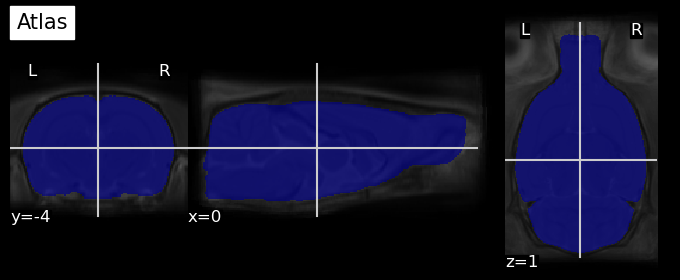

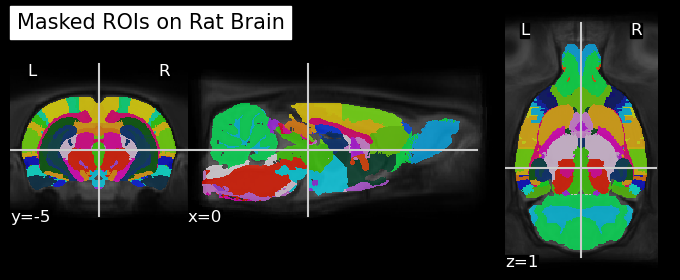

In [105]:
from nilearn import plotting

plotting.plot_roi(atlas_mask, bg_img=template_path, title="Atlas")
plotting.plot_roi(masker.labels_img_, bg_img=template_path, title='Masked ROIs on Rat Brain') 

#report = masker.generate_report()
#report

In [99]:
# - Extract signal based on SIGMA atlas - 
# Won't use it -> I can't deal with output T.T
# Quite long to run

for index in range(0, 1):
    
    subj_num=str(df.iloc[index]['rat.sub'])[:-2]
    print('index:', index)
    print('subj:', subj_num)
    
    subj_img = glob.glob("/project/4180000.19/multirat_stim/rabies/preprocess/sub-0{}_ses-1/bold_datasink/commonspace_bold/*/*/*.nii.gz".format(subj_num, subj_num, subj_num))[0]
    
    
     # - Load result from GLM analysis - 
        
    first_level_output = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level'
    zscores = nib.load(first_level_output +'/z_score/z_score_sub-0{}_ses-1.nii.gz'.format(subj_num))
    residuals = nib.load(first_level_output +'/residuals/residuals_sub-0{}_ses-1.nii.gz'.format(subj_num))
    beta_estimates = nib.load(first_level_output + '/beta_estimates/beta_sub-0{}_ses-1.nii.gz'.format(subj_num))
    effect_var = nib.load(first_level_output + '/effect_var/effect_var_sub-0{}_ses-1.nii.gz'.format(subj_num))
    predicted_timeseries = nib.load(first_level_output +'/predicted_timeseries/predicted_timeseries_sub-0{}_ses-1.nii.gz'.format(subj_num))

    
    # - Extract signal from regions - 

    masker_stand = NiftiLabelsMasker(labels_img=atlas_img, mask_img=atlas_mask, standardize=True, detrend=True).fit(subj_img)
    masker = NiftiLabelsMasker(labels_img=atlas_img, mask_img=atlas_mask, resampling_target='labels').fit(subj_img)

    z_scores = masker.fit_transform(zscores)
    print("Done z_scores")
    residuals = masker.fit_transform(residuals)
    print("Done residuals")
    effect_size = masker.fit_transform(beta_estimates)
    print("Done effect_size")
    effect_var = masker.fit_transform(effect_var)
    print("Done effect_var")
    real_timeseries = masker_stand.fit_transform(subj_img)
    print("Done real_timeseries")
    predicted_timeseries = masker.fit_transform(predicted_timeseries)
    print("Done predicted_timeseries")
    
         # Save as .csv file
    savetxt(mask_zscores_dir+'zscores_sub-0{}_ses-1.csv'.format(subj_num), z_scores, delimiter=',')     
    savetxt(residuals_dir+'residuals_sub-0{}_ses-1.csv'.format(subj_num), residuals, delimiter=',')     
    savetxt(effect_size_dir+'effect_size_sub-0{}_ses-1.csv'.format(subj_num), effect_size, delimiter=',')    
    savetxt(effect_variance_dir+'effect_var_sub_sub-0{}_ses-1.csv'.format(subj_num), effect_var, delimiter=',')    
    savetxt(real_timeseries_dir+'real_timeseries_sub-0{}_ses-1.csv'.format(subj_num), real_timeseries, delimiter=',') 
    savetxt(predicted_timeseries_dir+'predicted_timeseries_sub-0{}_ses-1.csv'.format(subj_num), predicted_timeseries, delimiter=',')    



index: 0
subj: 200100
Done z_scores


KeyboardInterrupt: 